# Tree of Thought (ToT) Prompting 技巧


* https://github.com/dave1010/tree-of-thought-prompting 參考資料
* 原本論文: https://github.com/princeton-nlp/tree-of-thought-llm

In [6]:
# Import necessary libraries
## 設定 OpenAI API Key 變數
from dotenv import load_dotenv
import os

# Load the environment variables from .env file
load_dotenv()

# Access the API key
openai_api_key = os.getenv('OPENAI_API_KEY')


In [7]:
import requests
import json
from pprint import pp

In [8]:
def get_completion(messages, model="gpt-3.5-turbo", temperature=0, max_tokens=2000):
  payload = { "model": model, "temperature": temperature, "messages": messages, "max_tokens": max_tokens }

  payload["seed"] = 0 # 為了重現一樣的結果，這裡固定了 seed

  headers = { "Authorization": f'Bearer {openai_api_key}', "Content-Type": "application/json" }
  response = requests.post('https://api.openai.com/v1/chat/completions', headers = headers, data = json.dumps(payload) )
  obj = json.loads(response.text)
  if response.status_code == 200 :
    return obj["choices"][0]["message"]["content"]
  else :
    return obj["error"]

## 比較 ToT 和其他 prompt 技巧的結果

In [17]:
question = """
Alice在書房裡。
她拿著一本書走到陽台。
她把一支筆夾在書裡，然後帶著書走到廚房。
她把書打開並朝下，然後走到客廳。
她在客廳裡放下書，然後走到院子。
發現夾在書中的筆不見了。
請問筆在哪裡？
"""

messages = [
    {
        "role": "user",
        "content": question
    }
]

response = get_completion(messages, temperature=0)
print(response)

筆在書裡。Alice把筆夾在書裡後，一直帶著書走到院子，所以筆就在書裡面。


❌❌❌ 直接問結果肯定是錯的，筆應該掉在廚房裡面!!

> 採用 Zero-shot CoT 試試看效果

In [14]:
messages = [
    {
        "role": "user",
        "content": question + "\n Think step by step, carefully and logically, explaining your answer."
    }
]

response = get_completion(messages, temperature=0)
print(response)

根據故事描述，Alice最後一次看到筆是在書裡夾著的，然後她帶著書走到了廚房。因此，筆應該還在書裡，只是Alice忘記了把筆從書中取出來。所以筆應該在書裡，放在廚房裡。


## ToT 法:

The “Tree of Thoughts” concept, on the other hand, is a more complex and hierarchical approach. Instead of a linear chain, ideas are organized into a tree-like structure, with each idea branching off into multiple related ideas.



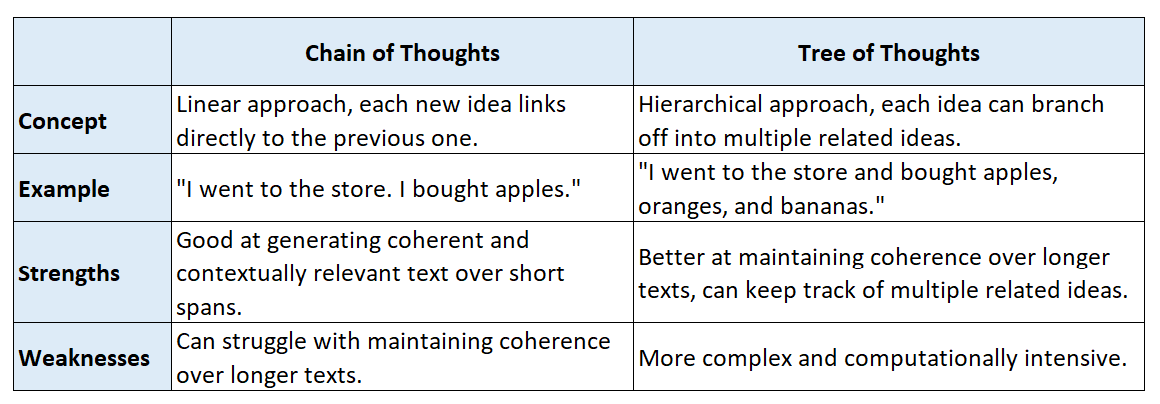


- 供詳細背景資訊：先提供包含多個相關概念的詳細背景資訊，這樣可以鼓勵模型生成更多分支的回答。
  
例子：如果討論醫療數據處理，提供病人數據管理、隱私保護、大數據分析等多個相關概念。

- 問開放式問題：不要問只能得到單一答案的直接問題，而是問可以引出多個可能答案的開放式問題。
  
例子："有哪些方法可以提高醫療數據的安全性和可用性？"

- 使用跟進問題：在模型生成回答後，使用跟進問題探索回答的不同方面，鼓勵模型生成更詳細和細緻的回答。
  
例子：對於回答中的某一方法，進一步詢問："這種方法在實際應用中有哪些挑戰？"

- 引導對話：如果模型開始偏離主題或失去連貫性，通過重申主要概念或提出更具體的問題來輕柔地引導它回到正軌。
  
例子："剛才提到的數據隱私保護方法，可以詳細說明其實現步驟嗎？"

## 嘗試使用如下 prompt 架構，讓模型產生不同思路

有各種 prompt 版本，不總是成功:

prompt 翻譯版本1:

想像有三位不同的專家在回答這個問題。所有專家都會寫下他們思考的第一步，然後與小組分享。然後所有的專家都會繼續進行下一步等等。如果有任何專家在任何時候意識到他們是錯的，那麼他們就離開。這個問題是...

prompt 翻譯版本2:

模擬三位卓越、邏輯性強的專家協作回答一個問題。每個人都詳細地解釋他們的思考過程，並考慮到其他人之前的解釋，並公開承認錯誤。在每一步中，只要可能，每位專家都會完善和建立在其他人的思考之上，並承認他們的貢獻。他們繼續直到有一個明確的答案為止。為了清晰起見，您的整個回答應該是在一個markdown表格中。問題是...

prompt 翻譯版本3:

辨別和扮演三位不同的適合回答此問題的專家。
所有的專家都會寫下這一步及他們對這一步的思考，然後與小組分享。
然後，所有的專家都會繼續進行下一步等等。
在每一步中，所有的專家都會給予他們同事的回答一個1到5的評分，1表示這是高度不可能的，5表示這是高度可能的。
如果有任何專家在任何時候被認為是錯誤的，那麼他們就離開。
在所有的專家都提供了他們的分析之後，你然後分析所有3個分析並提供共識解決方案或你的最佳猜測解決方案。

In [20]:
question = """
Alice在書房裡。
她拿著一本書走到陽台。
她把一支筆夾在書裡，然後帶著書走到廚房。
她把書打開並朝下，然後走到客廳。
她在客廳裡放下書，然後走到院子。
發現夾在書中的筆不見了。
請問筆在哪裡？
"""

user_message = f"""
請識別並扮演三個適合回答這個問題的專家。
所有專家將逐步寫下他們對每一步的思考，然後與小組分享。
然後，所有專家將進行下一步，依此類推。
在每一步中，所有專家將對同儕的回應進行 1 到 5 的評分，1 表示極不可能，5 表示極有可能。
如果任何專家在某個點被判斷為錯誤，則他們將離開。
在所有專家提供分析後，你將分析所有三個分析並提供共識解決方案或最佳猜測解決方案。
問題是：```{question}```

"""

messages = [
    {
        "role": "user",
        "content": user_message
    }
]

response = get_completion(messages, temperature=0, max_tokens=4096, model="gpt-4-turbo")
print(response)

專家1：偵探專家
思考過程：
1. Alice首先在書房拿起書，然後走到陽台，這時她把筆夾在書裡。這表示筆最初是安全的。
2. Alice隨後帶著書走到廚房，並把書打開朝下放置。這個動作可能導致夾在書中的筆因重力作用而滑落。
3. Alice將書帶到客廳並放下，然後走到院子。這時她發現筆不見了。

結論：筆很可能在廚房，因為那是Alice唯一打開書的地方，筆可能在那時掉落。

專家2：物理學家
思考過程：
1. 考慮到筆的物理特性，夾在書頁中的筆在移動過程中可能會因為震動或書的傾斜而滑落。
2. Alice在廚房打開書並朝下放置，這個動作可能導致筆因重力直接掉落。
3. 在客廳和院子的過程中，Alice沒有再次打開書，因此筆的丟失應該發生在廚房。

結論：筆最有可能在廚房，因為那是筆最可能因動作而掉落的地方。

專家3：心理學家
思考過程：
1. 從心理學角度分析，人們在轉移注意力時可能會忽略某些細節，如物品的位置。
2. Alice在廚房打開書時可能因為專注於其他事物（如烹飪），而未注意到筆的掉落。
3. 在客廳和院子的過程中，Alice可能已經忘記了筆的存在，直到她需要使用筆時才意識到筆不見了。

結論：筆很可能在廚房，因為那是Alice最有可能因分心而忽略筆掉落的地方。

共識解決方案：
根據三位專家的分析，共同的結論是筆很可能在廚房。這是因為廚房是Alice唯一打開書的地方，且動作可能導致筆掉落。因此，最佳猜測是筆在廚房。
